[View in Colaboratory](https://colab.research.google.com/github/sandroormeno/Tensorflow-basic-examples/blob/master/mnist_sandro_multicapa_con_mejoras_rate_decay.ipynb)

**Aprendizaje: 98.24  %**
Pérdida:  7.8238735

In [1]:
%matplotlib  inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import numpy as np
print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

Tensorflow version 1.10.0


In [2]:
#Comprobamos poder utilizar la gpu para procesar
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True,  reshape=False)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
def ver(i):
    plt.imshow(mnist.train.images[i].reshape((28,28)), cmap="gray")
    plt.axis('off')

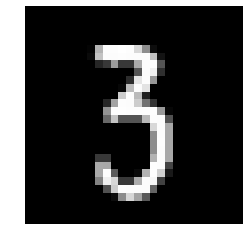

In [6]:
ver(432)
#mnist.train.images[2]

In [0]:
L = 200
M = 100
N = 60
O = 30

# entrada X: 28x28 imágenes en escala de grises, la primera dimensión (Ninguna) indexará las imágenes en el mini-bach
#X = tf.placeholder(tf.float32, [None, 28, 28, 1])
X = tf.placeholder(tf.float32,[None, 784])
# las salidas (respuestas) correctas irán aquí
Y_ = tf.placeholder(tf.float32, [None, 10])
# pesos sinápticos W[784, 10]   784=28*28
step = tf.placeholder(tf.int32)

lr = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([L])/10)
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.zeros([M])/10)
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.zeros([N])/10)
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.zeros([O])/10)
W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

# el modelo de la salida
# multipocación de x por W , más B
# matmul es una funsión de TF para  multiplicación
#Y = tf.nn.softmax(tf.matmul(X, W) + b)

Y1 = tf.nn.relu (tf.matmul(X, W1) + B1)
Y2 = tf.nn.relu (tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.relu (tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.relu (tf.matmul(Y3, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)


# cross-entropy
# log toma el log de cada elemento, * multiplica el elemento tensores por elemento
# reduce_mean agregará todos los componentes en el tensor
# así que aquí terminamos con la cross-entropy total para todas las imágenes en el batch
#cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0  # normalizado para lotes de 100 imágenes,
#cross_entropy = tf.reduce_mean(tf.square(Y_-Y))# *10 porque "reduce_mean" incluyó una división no deseada por 10

#cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# precisión del modelo entrenado, entre 0 (peor) y 1 (mejor)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step
# the learning rate is: # 0.0001 + 0.003 * (1/e)^(step/2000)), i.e. exponential decay from 0.003->0.0001
lr = 0.0001 +  tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

Produccion = tf.argmax(Ylogits,1)

In [8]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

testPerformance = []
trainPerformance = []
testloss = []
trainloss = []

def training_step(i, update_test_data, update_train_data):

    # entrenamiento en lotes de 100 imágenes con 100 etiquetas
    batch_X, batch_Y = mnist.train.next_batch(100)

    # calcular los valores de entrenamiento para la visualización
    if update_train_data:
        #a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y})
        aa, cc = sess.run([accuracy, cross_entropy], {X: mnist.test.images, Y_: mnist.test.labels})
        
        print(str(i) + ": aprendizaje:" + str(a) + " pérdida: " + str(c))
        trainPerformance.append(a)
        trainloss.append(c)
        testPerformance.append(aa)
        testloss.append(cc)

    # calcular los valores de test para la visualización
    if update_test_data:
        #a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        a, c = sess.run([accuracy, cross_entropy], {X: mnist.test.images, Y_: mnist.test.labels})
        print(str(i) + ": ********* epoca " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test aprendizaje:" + str(a) + " test pérdida: " + str(c))

    # the back propagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y, step: i})
    
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.device('/gpu:0'):
  for i in range(5000+1): 
      training_step(i, i % 100 == 0, i % 10 == 0)

0: aprendizaje:0.08 pérdida: 230.95016
0: ********* epoca 1 ********* test aprendizaje:0.1079 test pérdida: 229.77898
10: aprendizaje:0.61 pérdida: 123.26591
20: aprendizaje:0.74 pérdida: 74.76908
30: aprendizaje:0.76 pérdida: 60.979607
40: aprendizaje:0.86 pérdida: 44.259327
50: aprendizaje:0.89 pérdida: 37.46103
60: aprendizaje:0.87 pérdida: 41.95166
70: aprendizaje:0.87 pérdida: 38.7869
80: aprendizaje:0.88 pérdida: 41.909737
90: aprendizaje:0.89 pérdida: 31.01358
100: aprendizaje:0.94 pérdida: 19.885307
100: ********* epoca 1 ********* test aprendizaje:0.909 test pérdida: 29.409023
110: aprendizaje:0.93 pérdida: 20.217127
120: aprendizaje:0.93 pérdida: 26.933804
130: aprendizaje:0.92 pérdida: 21.21349
140: aprendizaje:0.91 pérdida: 20.948008
150: aprendizaje:0.93 pérdida: 19.36013
160: aprendizaje:0.89 pérdida: 34.974705
170: aprendizaje:0.93 pérdida: 16.925102
180: aprendizaje:0.93 pérdida: 19.45074
190: aprendizaje:0.93 pérdida: 34.42686
200: aprendizaje:0.94 pérdida: 18.253756
2

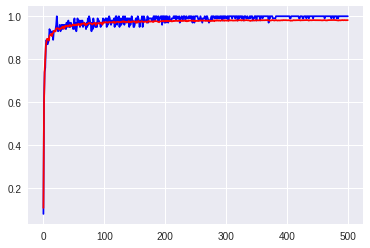

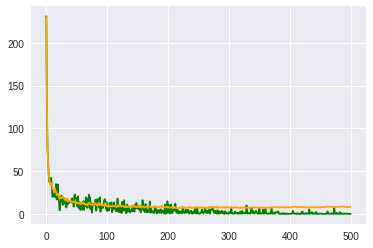

In [9]:
plt.plot(trainPerformance, "b")
plt.plot(testPerformance, "r")
plt.show()
plt.plot(trainloss, "green")
plt.plot(testloss, "orange")
plt.show()

In [0]:
def suerte(imagen):
    prediccion  = sess.run(Produccion,feed_dict={X: mnist.test.images[imagen].reshape(1,784)})
    print("La imagen es: {:}".format (prediccion))
    plt.imshow(mnist.test.images[imagen].reshape((28,28)), cmap="gray")
    plt.axis('off')

La imagen es: [6]


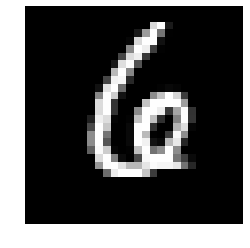

In [11]:
suerte(123)